In [1]:
class Benchmark:
    """ Opcje dla benchmarka """
    def __init__(self, *, output_size=1, input_size=lambda size: size*size*3, interesting=True,
                 filter=lambda df: df):
        """
            output_size – wskazuje, jak zależy rozmiar wyjścia operatora od rozmiaru wejścia.
                          Może być liczbą (skala) lub funkcją.
            input_size – jak obliczyć rozmiar wejścia z rozmiaru obrazka
            interesting – oznacza, czy operator ma być wyróżniony na wykresie
        """
        if type(output_size) == int or type(output_size) == float:
            self.output_size = lambda input_size: output_size * input_size
        else:
            self.output_size = output_size
        self.input_size = input_size
        self.interesting = interesting
        self.filter = filter
            
BENCHMARKS = {
    'CopyGPU': Benchmark(),
    'FlipGPU': Benchmark(),
    'ColorTwistGPU': Benchmark(),
    #'ResizeGPU': Benchmark(),
    'FlipGPU': Benchmark(),
    'CoinFlipGPU': Benchmark(output_size=1/3),
    'TransposeGPU': Benchmark(),
    'CastGPU': Benchmark(output_size=4.), #uint8 -> float
    'ColorTwistGPU': Benchmark(),
    'SliceGPU': Benchmark(),
    'CropGPU': Benchmark(),

    'GaussianBlurGPU': Benchmark(), # Nie robi 2000x2000
    'CropMirrorNormalizeX': Benchmark(filter=lambda df: df[df['name'].str.contains('900/900/9/1/1/1')], output_size=(9/10)**2),
    
    # Niejasne ilości przetwarzanych bajtów
    #'OneHotGPU': Benchmark(),
    #'ReshapeGPU': Benchmark()
    #'NormalDistributionX': Benchmark(),
    #'NormalDistribution_NonUniform': Benchmark(),
}

SPEED_OF_LIGHT = 'CopyGPU'  # Benchmark używany jako speed-of-light
GPU_THEORETICAL_THROUGHPUT = 651.3  # Teoretyczna przepustowość karty w GB/s
RESULTS_DIR = '/home/public/benchmarks/results'

GB = 1024**3

In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import json
import numpy as np

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def load_results():
    files = [os.path.join(RESULTS_DIR, f) for f in os.listdir(RESULTS_DIR)]
    data = []
    for f in files:
        if not f.endswith('json'):
            continue
        print(f'Loading {f}')
        try:
            d = json.load(open(f, 'r'))
            d = d['benchmarks']
        except json.JSONDecodeError:
            print('Invalid file', f)
            continue
        keys = sum([list(elem.keys()) for elem in d], [])
        data.append(pd.DataFrame({k: [elem[k] for elem in d] for k in keys}))
    df = pd.concat(data)
    
    # Jest po jednym wyniku, więc nie chcemy mediany
    #df = df[df['name'].str.contains('real_time_median')]  # Chcemy tylko medianę
    
    # Ustalamy czas w sekundach
    assert(all(df['time_unit'] == 'us'))  # Jeśli nie, to wypadałoby naklepać konwersję
    df['time'] = df['real_time'] / 1e6  # Jest też CPU time, które lepsze?
    
    # Wyciągamy potrzebne info z `name`
    df[['operator', 'batch', 'size', 'iterations']] = \
        df['name'].str.extract(r'OperatorBench/([A-Za-z]*)/(\d+)/(\d+)/.*iterations:(\d+).*')
    df[['batch', 'size', 'iterations']] = df[['batch', 'size', 'iterations']].astype(float)
    
    # Wycinamy tylko potrzebne pola
    df = df[['name', 'operator', 'batch', 'size', 'iterations', 'time']]
    df.reset_index(drop=True, inplace=True)
    
    def add_output_size(row):
        op = row['operator']
        if op in BENCHMARKS:
            return BENCHMARKS[op].output_size(row['input_bytes'])
        else:
            return np.nan
        
    def add_input_size(row):
        op = row['operator']
        if op in BENCHMARKS:
            return BENCHMARKS[op].input_size(row['size']) * row['batch']
        else:
            return np.nan
        
    
    # Dodajemy informacje o rozmiarze danych i przepustowości
    df['input_bytes'] = df.apply(add_input_size, axis=1)
    df['output_bytes'] = df.apply(add_output_size, axis=1)
    df['bytes'] = df['input_bytes'] + df['output_bytes']
    df['throughput'] = df['bytes'] / df['time']
    return df

results = load_results()


Loading /home/public/benchmarks/results/ReshapeGPU_result.json
Loading /home/public/benchmarks/results/MinGPU_result.json
Invalid file /home/public/benchmarks/results/MinGPU_result.json
Loading /home/public/benchmarks/results/GaussianBlurGPU_result.json
Loading /home/public/benchmarks/results/CopyGPU_result.json
Loading /home/public/benchmarks/results/ResizeGPU_result.json
Invalid file /home/public/benchmarks/results/ResizeGPU_result.json
Loading /home/public/benchmarks/results/NormalDistributionX_result.json
Loading /home/public/benchmarks/results/NormalDistribution_NonUniform_result.json
Loading /home/public/benchmarks/results/UniformGPU_result.json
Invalid file /home/public/benchmarks/results/UniformGPU_result.json
Loading /home/public/benchmarks/results/CropMirrorNormalizeX_result.json
Loading /home/public/benchmarks/results/FlipGPU_result.json
Loading /home/public/benchmarks/results/OneHotGPU_result.json
Loading /home/public/benchmarks/results/CoinFlipGPU_result.json
Loading /home

In [5]:
def filter_results(df, *, max_batch=None, op=None, size=None):
    if max_batch:
        df = df[df['batch'] <= max_batch]
    if op:
        df = df[df['operator'] == op]
        df = BENCHMARKS[op].filter(df)
    if size:
        df = df[df['size'] == size]
    return df

def get_imgsize(df):
    size = df['size'].iloc[0]
    assert all(df['size'] == size)
    return size

def draw_theoretical_throughput(plt):
    plt.axhline(GPU_THEORETICAL_THROUGHPUT, color='black', linestyle=':')
    plt.annotate(f'Theoretical throughput', 
                 xy=(0, GPU_THEORETICAL_THROUGHPUT-17), fontsize=7)

In [6]:
def plot_all(plt, df, suffix='', **kwargs):
    plt.figure(figsize=(10, 5), dpi=80)
    df = filter_results(results, **kwargs)
    for op in BENCHMARKS:
        this = filter_results(df, op=op)
        assert len(df) > 0, f'No data for {op}'
        
        plot_kwargs = {}
        if BENCHMARKS[op].interesting or op == SPEED_OF_LIGHT:
            plot_kwargs['label'] = op
        else:
            plot_kwargs['color'] = 'gray'
        if op == SPEED_OF_LIGHT:
            plot_kwargs['color'] = 'red'
            plot_kwargs['linestyle'] = ':'
        plt.plot(this['batch'], this['throughput'] / GB, **plot_kwargs)
    
    draw_theoretical_throughput(plt)
    plt.title(f'Operators throughput (image size: {get_imgsize(df)})')
    plt.ylabel('Throughput [GB/s]')
    plt.xlabel('Batch size')
    plt.legend() 
    plt.ylim(ymin=0)
    plt.savefig(f'plots/all{suffix}.png', facecolor='white')
    

In [7]:
def plot_one(plt, df, op, suffix='', **kwargs):
    plt.figure(figsize=(10, 5), dpi=80)
    this = filter_results(results, op=op, **kwargs)
    sol = filter_results(results, op=SPEED_OF_LIGHT, **kwargs)
    assert len(df) > 0, f'No data for {op}'
    
    plt.plot(this['batch'], this['throughput'] / GB, label=op)
    plt.plot(sol['batch'], sol['throughput'] / GB, linestyle=':', color='red', label='Copy')
        
    plt.ylabel('Throughput [GB/s]')
    plt.xlabel('Batch size')
    
    draw_theoretical_throughput(plt)
    plt.legend()
    plt.title(f'{op}')
    plt.ylim(ymin=0)
    size = get_imgsize(this)
    plt.title(f'{op} throughput (image size: {size})')
    plt.savefig(f'plots/{op}{suffix}_{size}.png', facecolor='white')

CopyGPU
FlipGPU
ColorTwistGPU
CoinFlipGPU
TransposeGPU
CastGPU
GaussianBlurGPU
CropMirrorNormalizeX


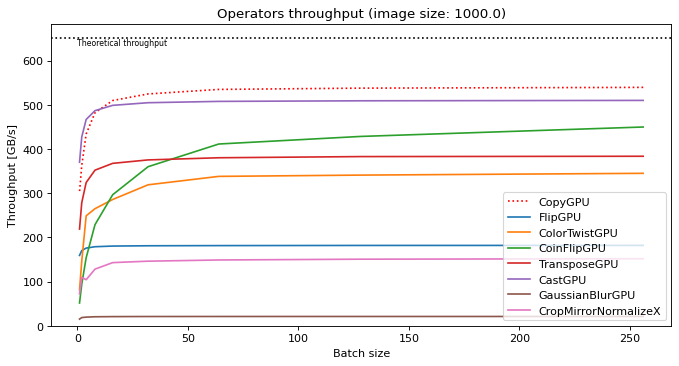

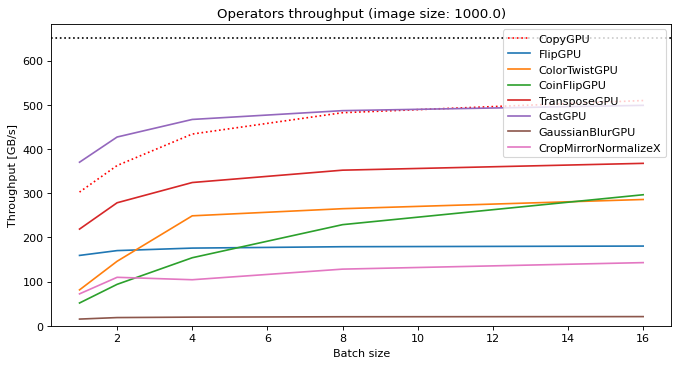

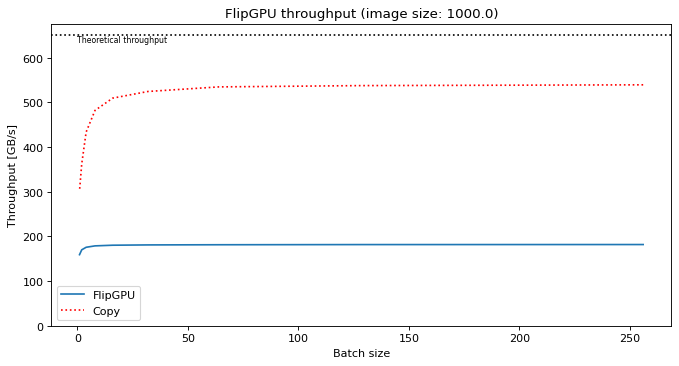

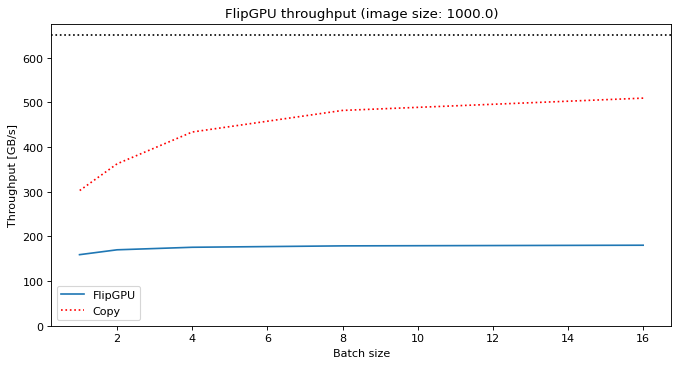

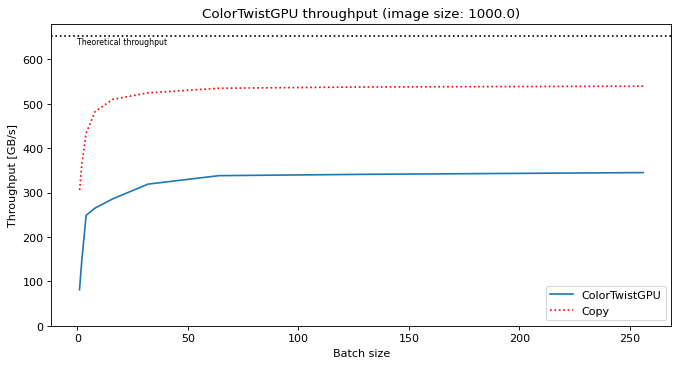

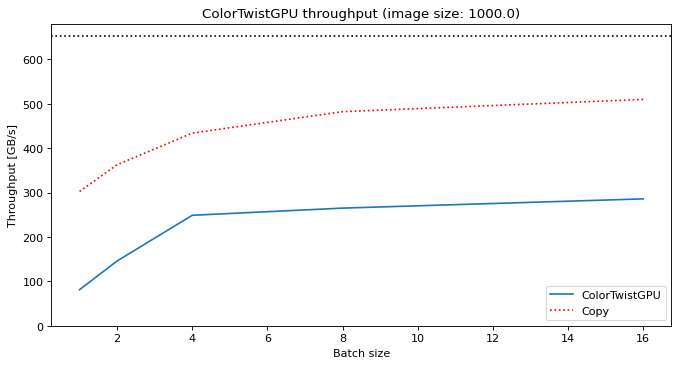

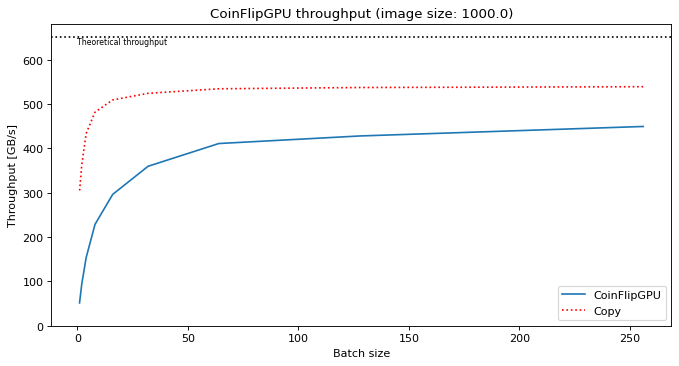

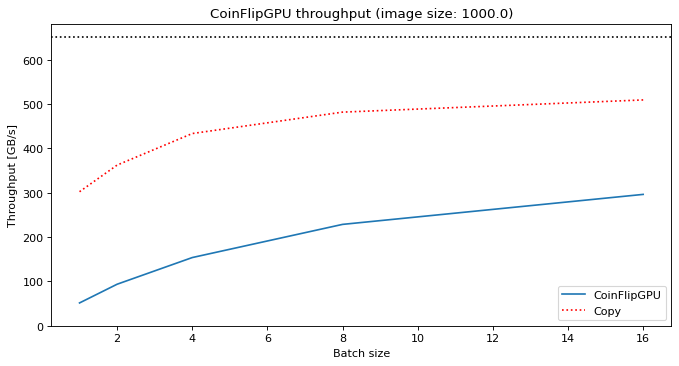

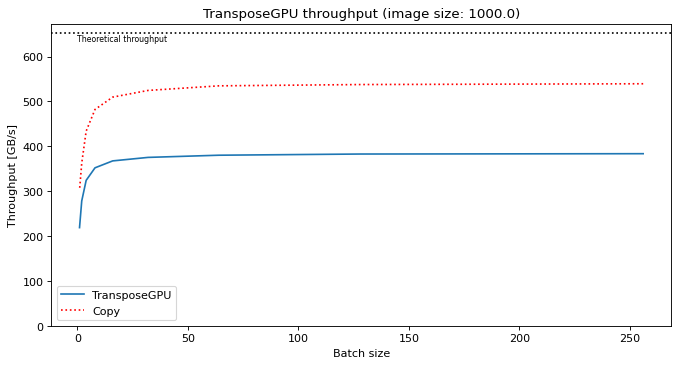

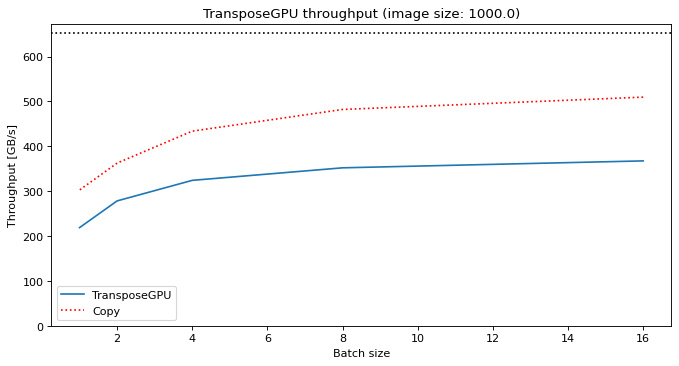

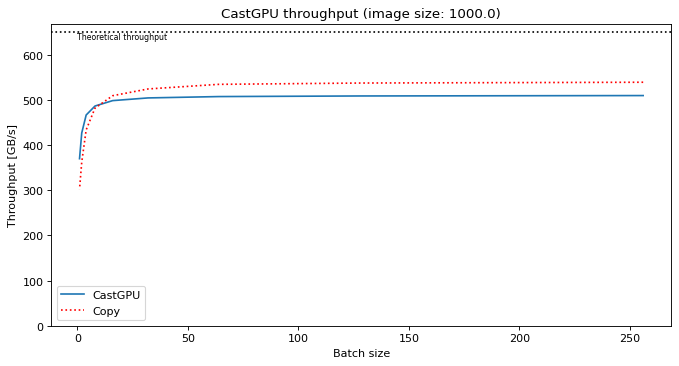

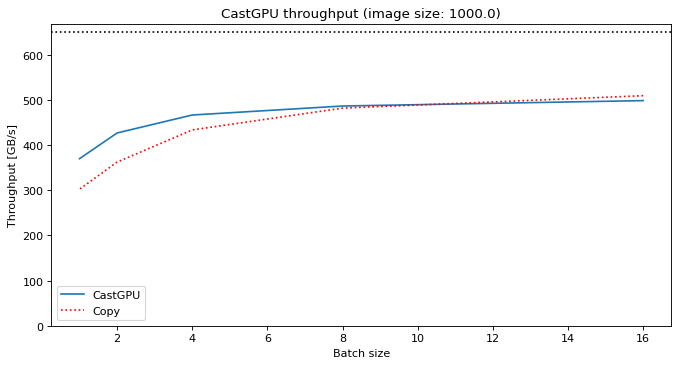

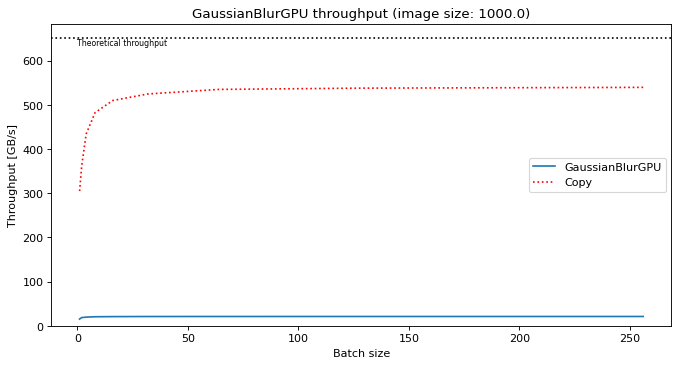

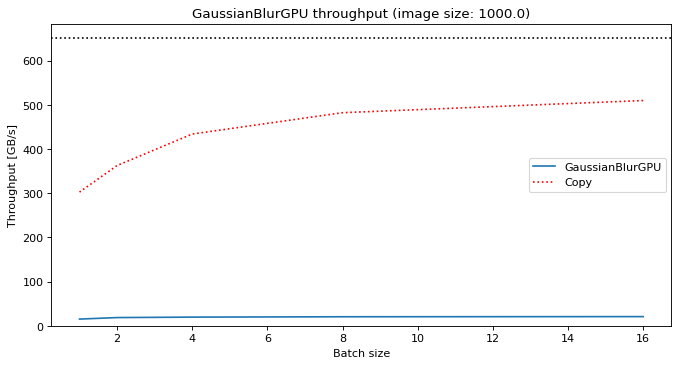

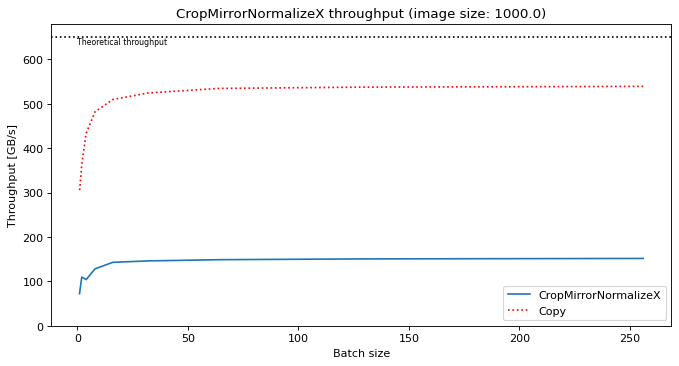

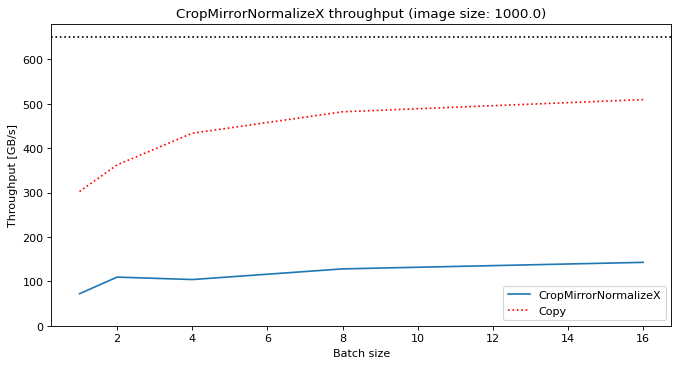

In [8]:
plot_all(plt, results, size=1000)
plot_all(plt, results, suffix='_small_batch', max_batch=16, size=1000)
for op in BENCHMARKS:
    print(op)
    if op == SPEED_OF_LIGHT: continue
    plot_one(plt, results, op, size=1000)
    plot_one(plt, results, op, suffix='_small_batch', max_batch=16, size=1000)